In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from scipy.stats import ranksums
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Set image dimensions
height, width = 224, 224
batch_size = 64

# Define function to generate data
def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)

    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='input',
        target_size=(height, width),
        classes=['Normal', 'Viral Pneumonia', 'Covid']
    )
    return generator

# Define training and testing directories
TRAINING_DIR = '/content/drive/MyDrive/Covid19-dataset/train'
TESTING_DIR = '/content/drive/MyDrive/Covid19-dataset/test'

# Generate train and test data
train_generator = generate_data(TRAINING_DIR)
# Load images and labels
data, labels = [], []
for _ in range(len(train_generator)):
    batch_data, batch_labels = next(train_generator)
    data.append(batch_data)
    labels.append(batch_labels)

# Flatten the images
train_data_flat = np.concatenate(data, axis=0).reshape(len(train_generator.filenames), -1)

test_generator = generate_data(TESTING_DIR)
# Load images and labels
tdata, tlabels = [], []
for _ in range(len(test_generator)):
    batch_data, batch_labels = next(test_generator)
    tdata.append(batch_data)
    tlabels.append(batch_labels)
# Flatten the images
test_data_flat = np.concatenate(tdata, axis=0).reshape(len(test_generator.filenames), -1)

# Set the dimensions of the latent space
latent_dim = 12

# Encoder
input_img = Input(shape=(height, width, 3))
x = Flatten()(input_img)
x = Dense(512, activation=relu)(x)
x = Dense(256, activation=relu)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(256, activation=relu)(decoder_input)
x = Dense(512, activation=relu)(x)
x = Dense(height * width * 3, activation='sigmoid')(x)
output_decoded = Reshape((height, width, 3))(x)

# VAE model
encoder = Model(input_img, [z_mean, z_log_var, z], name="encoder")
decoder = Model(decoder_input, output_decoded, name="decoder")
output_decoded_vae = decoder(encoder(input_img)[2])

vae = Model(input_img, output_decoded_vae)
vae_loss = tf.keras.losses.MeanSquaredError()
vae.compile(optimizer=Adam(learning_rate=0.001), loss=vae_loss)

# Train the VAE model
epochs = 700
steps_per_epoch = len(train_generator) // batch_size
validation_steps = len(test_generator) // batch_size

for epoch in range(epochs):
    #print(f"Epoch {epoch + 1}/{epochs}")
    for step in range(steps_per_epoch):
        x_batch, _ = next(train_generator)
        vae.train_on_batch(x_batch, x_batch)
    for step in range(validation_steps):
        x_batch, _ = next(test_generator)
        vae.test_on_batch(x_batch, x_batch)

# Encode data using the encoder part of the VAE model
train_encoded = encoder.predict(train_generator)
test_encoded = encoder.predict(test_generator)

# Concatenate the predicted values
train_encoded_concatenated = np.concatenate(train_encoded, axis=0)
test_encoded_concatenated = np.concatenate(test_encoded, axis=0)

# Flatten the concatenated encoded data if necessary
train_encoded_flat = train_encoded_concatenated.reshape(len(train_generator.filenames), -1)
test_encoded_flat = test_encoded_concatenated.reshape(len(test_generator.filenames), -1)

# Train a kNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(train_encoded_flat, train_generator.labels)

# Evaluate the kNN classifier
test_predictions = knn_classifier.predict(test_encoded_flat)
accuracy = accuracy_score(test_generator.labels, test_predictions)
print(f"Accuracy of kNN Classifier before resampling: {accuracy}")

# Train the SVM classifier
svm_classifier = SVC(kernel='rbf', probability=True)
svm_classifier.fit(train_encoded_flat, train_generator.labels)

# Evaluate the SVM classifier
test_predictions_svm = svm_classifier.predict(test_encoded_flat)
accuracy_svm = accuracy_score(test_generator.labels, test_predictions_svm)
print(f"Accuracy of SVM Classifier before resampling: {accuracy_svm}")


Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
2/2 [==============================] - 1s 48ms/step
Accuracy of kNN Classifier before resampling: 0.5757575757575758
Accuracy of SVM Classifier before resampling: 0.9090909090909091


In [ ]:
#SMOTEENN
sampling_strategy = {0: 200, 1: 200, 2: 200}
# Apply SMOTEENN to balance the classes in the training data
smote_enn = SMOTEENN(sampling_strategy=sampling_strategy, random_state=42)
train_data_balanced, train_labels_balanced = smote_enn.fit_resample(train_encoded_flat, train_generator.labels)

# Train a kNN classifier after applying SMOTEENN
knn_classifier_after = KNeighborsClassifier(n_neighbors=10)
knn_classifier_after.fit(train_data_balanced, train_labels_balanced)

# Predict using the combined data
test_predictions_after = knn_classifier_after.predict(test_encoded_flat)

# Evaluate the performance of the classifier on the test data after SMOTEENN
accuracy_after = accuracy_score(test_generator.labels[:len(test_data_flat)], test_predictions_after)
print(f"Accuracy of kNN Classifier after SMOTEENN: {accuracy_after}")

# Train the SVM classifier after applying SMOTEENN
svm_classifier_after = SVC(kernel='rbf', probability=True)
svm_classifier_after.fit(train_data_balanced, train_labels_balanced)

# Predict using the test_encoded_flat data
test_predictions_svm_after = svm_classifier_after.predict(test_encoded_flat)

# Evaluate the performance of the classifier on the test data after SMOTEENN
accuracy_svm_after = accuracy_score(test_generator.labels[:len(test_data_flat)], test_predictions_svm_after)
print(f"Accuracy of SVM Classifier after SMOTEENN: {accuracy_svm_after}")


Accuracy of kNN Classifier after SMOTEENN: 0.5303030303030303
Accuracy of SVM Classifier after SMOTEENN: 0.9090909090909091


In [ ]:
#SMOTE
sampling_smstrategy = {0: 200, 1: 200, 2: 200}
# Apply SMOTE to balance the classes in the training data
smote = SMOTE(sampling_strategy=sampling_smstrategy,random_state=50)
smote_train_data_balanced, smote_train_labels_balanced = smote.fit_resample(train_encoded_flat, train_generator.labels)

# Train a kNN classifier after applying SMOTE
knn_smote_classifier_after = KNeighborsClassifier(n_neighbors=10)
knn_smote_classifier_after.fit(smote_train_data_balanced, smote_train_labels_balanced)

# Predict using the combined data
test_smote_predictions_after = knn_smote_classifier_after.predict(test_encoded_flat)

# Evaluate the performance of the classifier on the test data after SMOTE
smote_accuracy_after = accuracy_score(test_generator.labels[:len(test_data_flat)], test_smote_predictions_after)
print(f"Accuracy of kNN Classifier after SMOTE: {smote_accuracy_after}")

# Train the SVM classifier after applying SMOTE
svm_smote_classifier_after = SVC(kernel='rbf', probability=True)
svm_smote_classifier_after.fit(smote_train_data_balanced, smote_train_labels_balanced)

# Predict using the test_encoded_flat data
test_sm_predictions_svm_after = svm_smote_classifier_after.predict(test_encoded_flat)

# Evaluate the performance of the classifier on the test data after SMOTE
accuracy_sm_svm_after = accuracy_score(test_generator.labels[:len(test_data_flat)], test_sm_predictions_svm_after)
print(f"Accuracy of SVM Classifier after SMOTE: {accuracy_sm_svm_after}")

Accuracy of kNN Classifier after SMOTE: 0.5606060606060606
Accuracy of SVM Classifier after SMOTE: 0.9090909090909091


Confusion matrix for kNN Classifier:
[[20  0  0]
 [ 2 18  0]
 [22  4  0]]



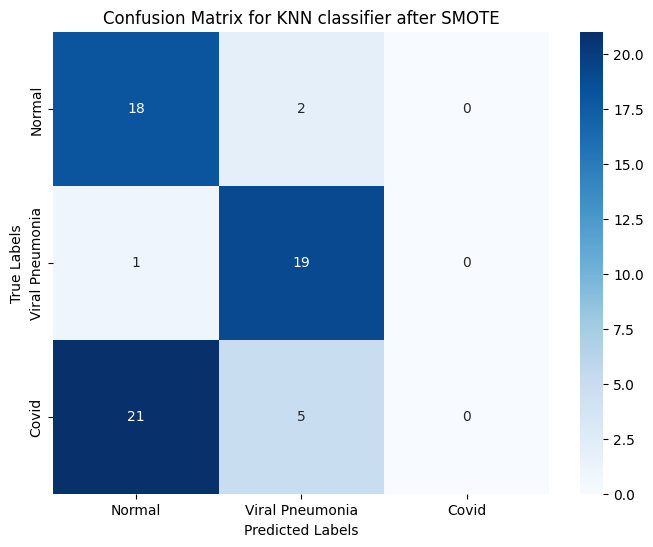

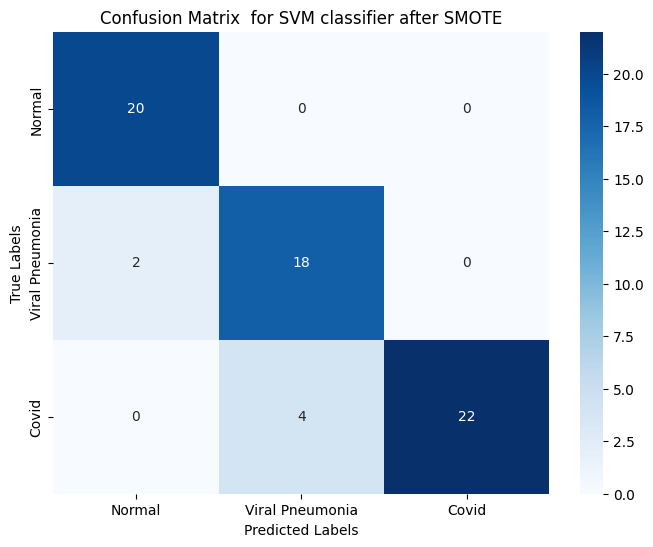

In [ ]:
# Confusion matrix for kNN classifier
confusion_knn = confusion_matrix(test_generator.labels, test_predictions)

# Confusion matrix for SVM classifier
confusion_svm = confusion_matrix(test_generator.labels, test_predictions_svm)

# Confusion matrix for kNN classifier after SMOTEENN
confusion_knn_after_smoteenn = confusion_matrix(test_generator.labels[:len(test_data_flat)], test_predictions_after)

# Confusion matrix for SVM classifier after SMOTEENN
confusion_svm_after_smoteenn = confusion_matrix(test_generator.labels[:len(test_data_flat)], test_predictions_svm_after)

# Confusion matrix for kNN classifier after SMOTE
confusion_knn_after_smote = confusion_matrix(test_generator.labels[:len(test_data_flat)], test_smote_predictions_after)

# Confusion matrix for SVM classifier after SMOTE
confusion_svm_after_smote = confusion_matrix(test_generator.labels[:len(test_data_flat)], test_sm_predictions_svm_after)

print("Confusion matrix for kNN Classifier:")
print(confusion_knn)
print()

# print("Confusion matrix for SVM Classifier:")
# print(confusion_svm)
# print()

# print("Confusion matrix for kNN Classifier after SMOTEENN:")
# print(confusion_knn_after_smoteenn)
# print()

# print("Confusion matrix for SVM Classifier after SMOTEENN:")
# print(confusion_svm_after_smoteenn)
# print()

# print("Confusion matrix for kNN Classifier after SMOTE:")
# print(confusion_knn_after_smote)
# print()

# print("Confusion matrix for SVM Classifier after SMOTE:")
# print(confusion_svm_after_smote)

# Define class labels
classes = ['Normal', 'Viral Pneumonia', 'Covid']

# Plot confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_knn_after_smote, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for KNN classifier after SMOTE')
plt.show()


plt.figure(figsize=(8, 6))
sns.heatmap(confusion_svm_after_smote, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix  for SVM classifier after SMOTE')
plt.show()

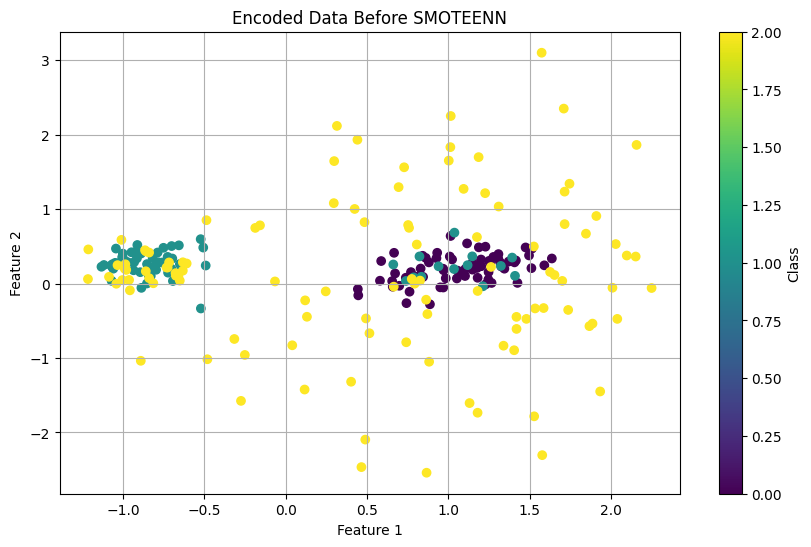

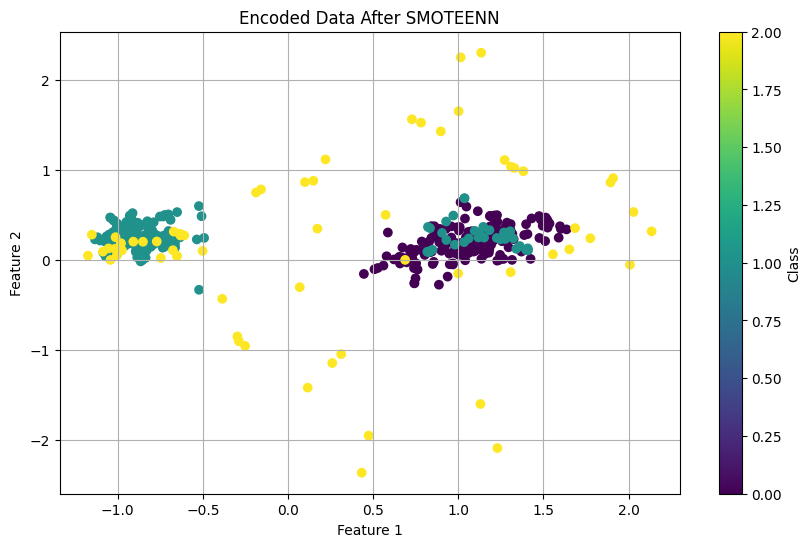

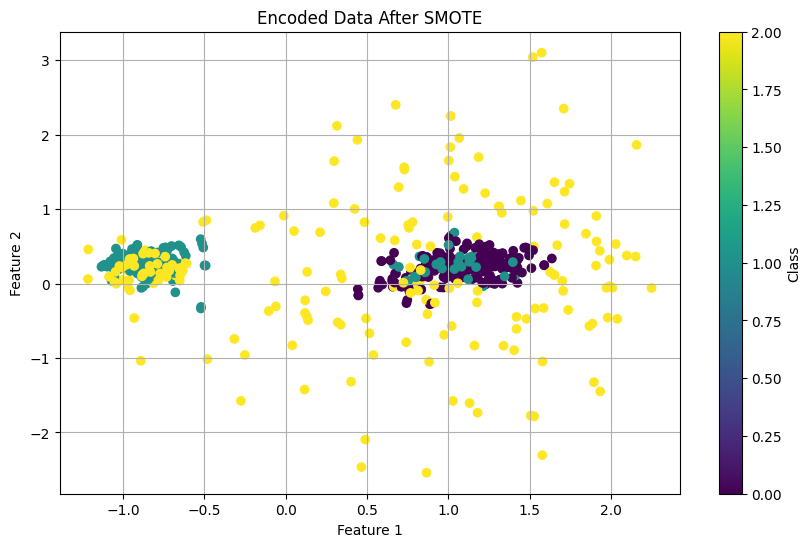

In [ ]:
import matplotlib.pyplot as plt

# Visualize encoded data before SMOTEENN
plt.figure(figsize=(10, 6))
plt.scatter(train_encoded_flat[:, 0], train_encoded_flat[:, 1], c=train_generator.labels, cmap='viridis')
plt.title('Encoded Data Before SMOTEENN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()

# Visualize encoded data after SMOTEENN
plt.figure(figsize=(10, 6))
plt.scatter(train_data_balanced[:, 0], train_data_balanced[:, 1], c=train_labels_balanced, cmap='viridis')
plt.title('Encoded Data After SMOTEENN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()

# Visualize encoded data after SMOTE
plt.figure(figsize=(10, 6))
plt.scatter(smote_train_data_balanced[:, 0], smote_train_data_balanced[:, 1], c=smote_train_labels_balanced, cmap='viridis')
plt.title('Encoded Data After SMOTE')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()

In [ ]:
# Define sampling strategy for ADASYN
sampling_strategy = {0: 111, 1: 111, 2: 111}

# Apply ADASYN to balance the classes in the training data
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
train_data_balanced_adasyn, train_labels_balanced_adasyn = adasyn.fit_resample(train_encoded_flat, train_generator.labels)

# Train a kNN classifier after applying ADASYN
knn_classifier_adasyn = KNeighborsClassifier(n_neighbors=10)
knn_classifier_adasyn.fit(train_data_balanced_adasyn, train_labels_balanced_adasyn)

# Predict using the test_encoded_flat data
test_predictions_adasyn = knn_classifier_adasyn.predict(test_encoded_flat)

# Evaluate the performance of the classifier on the test data after ADASYN
accuracy_adasyn = accuracy_score(test_generator.labels[:len(test_data_flat)], test_predictions_adasyn)
print(f"Accuracy of kNN Classifier after ADASYN: {accuracy_adasyn}")

# Train an SVM classifier after applying ADASYN
svm_classifier_adasyn = SVC(kernel='rbf', probability=True)
svm_classifier_adasyn.fit(train_data_balanced_adasyn, train_labels_balanced_adasyn)

# Predict using the test_encoded_flat data
test_predictions_svm_adasyn = svm_classifier_adasyn.predict(test_encoded_flat)

# Evaluate the performance of the classifier on the test data after ADASYN
accuracy_svm_adasyn = accuracy_score(test_generator.labels[:len(test_data_flat)], test_predictions_svm_adasyn)
print(f"Accuracy of SVM Classifier after ADASYN: {accuracy_svm_adasyn}")


Accuracy of kNN Classifier after ADASYN: 0.5757575757575758
Accuracy of SVM Classifier after ADASYN: 0.9090909090909091


In [ ]:
# Get the predicted probabilities for each class
test_probabilities_knn = knn_classifier.predict_proba(test_encoded_flat)
test_probabilities_svm = svm_classifier.predict_proba(test_encoded_flat)
test_probabilities_knn_after = knn_classifier_after.predict_proba(test_encoded_flat)
test_probabilities_svm_after = svm_classifier_after.predict_proba(test_encoded_flat)
test_probabilities_smote = knn_smote_classifier_after.predict_proba(test_encoded_flat)
test_probabilities_sm = svm_smote_classifier_after.predict_proba(test_encoded_flat)
test_probabilities_adasyn = knn_classifier_adasyn.predict_proba(test_encoded_flat)
test_probabilities_svm_adasyn = svm_classifier_adasyn.predict_proba(test_encoded_flat)

# Calculate AUC score for kNN Classifier before resampling
auc_knn_before_smote = roc_auc_score(test_generator.labels[:len(test_data_flat)], test_probabilities_knn, multi_class='ovr')
print(f"AUC Score of kNN Classifier before resampling: {auc_knn_before_smote}")

# Calculate AUC score for SVM Classifier before resampling
auc_svm_before_smote = roc_auc_score(test_generator.labels[:len(test_data_flat)], test_probabilities_svm, multi_class='ovr')
print(f"AUC Score of SVM Classifier before resampling: {auc_svm_before_smote}")

# Calculate AUC score for kNN Classifier after SMOTEENN
auc_knn_after_smoteenn = roc_auc_score(test_generator.labels[:len(test_data_flat)], test_probabilities_knn_after, multi_class='ovr')
print(f"AUC Score of kNN Classifier after SMOTEENN: {auc_knn_after_smoteenn}")

# Calculate AUC score for SVM Classifier after SMOTEENN
auc_svm_after_smoteenn = roc_auc_score(test_generator.labels[:len(test_data_flat)], test_probabilities_svm_after, multi_class='ovr')
print(f"AUC Score of SVM Classifier after SMOTEENN: {auc_svm_after_smoteenn}")

# Calculate AUC score for kNN Classifier after SMOTE
auc_knn_after_smote = roc_auc_score(test_generator.labels[:len(test_data_flat)], test_probabilities_smote, multi_class='ovr')
print(f"AUC Score of kNN Classifier after SMOTE: {auc_knn_after_smote}")

# Calculate AUC score for SVM Classifier after SMOTE
auc_svm_after_smote = roc_auc_score(test_generator.labels[:len(test_data_flat)], test_probabilities_sm, multi_class='ovr')
print(f"AUC Score of SVM Classifier after SMOTE: {auc_svm_after_smote}")

# Calculate AUC score for kNN Classifier after ADASYN
auc_knn_after_adasyn = roc_auc_score(test_generator.labels[:len(test_data_flat)], test_probabilities_adasyn, multi_class='ovr')
print(f"AUC Score of kNN Classifier after ADASYN: {auc_knn_after_adasyn}")

# Calculate AUC score for SVM Classifier after ADASYN
auc_svm_after_adasyn = roc_auc_score(test_generator.labels[:len(test_data_flat)], test_probabilities_svm_adasyn, multi_class='ovr')
print(f"AUC Score of SVM Classifier after ADASYN: {auc_svm_after_adasyn}")



AUC Score of kNN Classifier before resampling: 0.6880365105908585
AUC Score of SVM Classifier before resampling: 0.952773132664437
AUC Score of kNN Classifier after SMOTEENN: 0.708974358974359
AUC Score of SVM Classifier after SMOTEENN: 0.9440496098104795
AUC Score of kNN Classifier after SMOTE: 0.7232023411371237
AUC Score of SVM Classifier after SMOTE: 0.9291387959866221
AUC Score of kNN Classifier after ADASYN: 0.6665203455964326
AUC Score of SVM Classifier after ADASYN: 0.952814938684504
